In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
from particles import resampling as rs
import time
import importlib
import sys
sys.path.append('..')

import GaussianMixtureAlgorithms as algo
importlib.reload(algo)

<module 'GaussianMixtureAlgorithms' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture/GaussianMixtureAlgorithms.py'>

In [2]:
import pandas as pd

df = pd.read_csv('../Gaussian/Corrmat_20DGaussian.csv', header = None)

C = df.to_numpy()

In [3]:
d = 20
w1 = 1/2
w2 = 1/3
w3 = 1/6

m3 = 5*np.ones(d)
m3[::2] = 2

M = np.ones((d, d))
M[0, 1] = M[1, 0] = -1
M[2, 3] = M[3, 2] = -1

weights = np.array([w1, w2, w3])
ms = np.array([3*np.ones(d), 4*np.ones(d), m3])
Sigmas = np.array([2*C, 2*C, linalg.inv(M*C)])
mu0 = np.zeros(d)
Sigma0 = np.eye(d)

logdets = np.log([linalg.det(Sigmas[0,:,:]), linalg.det(Sigmas[1,:,:]), linalg.det(Sigmas[2,:,:])])
Sigmas_inv = np.array([linalg.inv(Sigmas[0,:,:]), linalg.inv(Sigmas[1,:,:]), linalg.inv(Sigmas[2,:,:])])

In [4]:
# d = 20
# w1 = 1.2/3
# w2 = 0.6/3
# w3 = 1.2/3

# M = np.ones((d, d))
# M[0, 1] = M[1, 0] = -1
# M[10, 1] = M[10, 1] = -1

# weights = np.array([w1, w2, w3])
# ms = np.array([3*np.ones(d), 7*np.ones(d), 2*np.ones(d)])
# Sigmas = np.array([2*C, M*C, 2*C])
# mu0 = np.zeros(d)
# Sigma0 = np.eye(d)

# logdets = np.log([linalg.det(Sigmas[0,:,:]), linalg.det(Sigmas[1,:,:]), linalg.det(Sigmas[2,:,:])])
# Sigmas_inv = np.array([linalg.inv(Sigmas[0,:,:]), linalg.inv(Sigmas[1,:,:]), linalg.inv(Sigmas[2,:,:])])

In [5]:
# d = 20
# w1 = 1/3
# w2 = 1/6
# w3 = 1/6
# w4 = 1-w1-w2-w3

# m2 = 9*np.ones(d)
# m2[::2] = 10

# m4 = 8*np.ones(d)
# m4[::2] = 4

# M = np.ones((d, d))
# M[0, 1] = M[1, 0] = -1
# M[2, 3] = M[3, 2] = -1

# weights = np.array([w1, w2, w3])
# weights = weights/np.sum(weights)
# ms = np.array([3*np.ones(d), m4, 2*np.ones(d)])
# Sigmas = np.array([0.7*C, 0.7*C, 2*C])
# mu0 = np.zeros(d)
# Sigma0 = np.eye(d)

# logdets = np.log([linalg.det(Sigmas[0,:,:]), linalg.det(Sigmas[1,:,:]), linalg.det(Sigmas[2,:,:])])
# Sigmas_inv = np.array([linalg.inv(Sigmas[0,:,:]), linalg.inv(Sigmas[1,:,:]), linalg.inv(Sigmas[2,:,:])])

In [6]:
true_mean = np.sum(ms * weights[:, np.newaxis], axis = 0)
true_variance = np.zeros((weights.size, d, d))
for i in range(weights.size):
    true_variance[i, :] = Sigmas[i, :, :] + np.matmul((ms[i, :] - true_mean)[:, None], (ms[i, :] - true_mean)[:, None].T)
    true_variance[i, :] = weights[i]*true_variance[i, :]
true_variance = np.sum(true_variance, axis = 0)

## Algorithms

In [7]:
N = 1000
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)
gamma = 0.1

nmcmc = 1

In [8]:
component = np.random.choice(weights.size, N*10, p=weights)
true_sample = np.zeros((N, d))
for n in range(N):
      true_sample[n, :] = np.random.multivariate_normal(ms[component[n], :], Sigmas[component[n], :, :], size = 1)[0]

In [9]:
Niter = 1000

Niter_ula = int(Niter*2.5)
Niter_mala = Niter
Niter_fr = int(Niter*1.6)
Niter_smcula = int(Niter*1.7)
Niter_smcmala = Niter

In [10]:
gamma_mala = 0.25
gamma_smcmala = 0.25

In [11]:
Nalgo = 6
Nrep = 1

runtime = np.zeros((Nrep, Nalgo))

In [12]:
w1_ula = np.zeros((Nrep, Niter_ula, d))
w1_mala = np.zeros((Nrep, Niter_mala, d))
w1_fr = np.zeros((Nrep, Niter_fr, d))
w1_wfr = np.zeros((Nrep, Niter, d))
w1_smcula = np.zeros((Nrep, Niter_smcula, d))
w1_smcmala = np.zeros((Nrep, Niter_smcmala, d))

cov_ula = np.zeros((Nrep, Niter_ula))
cov_mala = np.zeros((Nrep, Niter_mala))
cov_fr = np.zeros((Nrep, Niter_fr))
cov_wfr = np.zeros((Nrep, Niter))
cov_smcula = np.zeros((Nrep, Niter_smcula))
cov_smcmala = np.zeros((Nrep, Niter_smcmala))

In [13]:
for i in range(Nrep):
    ## ULA
    start = time.time()
    ula_chain, w1_ula[i,:], cov_ula[i,:] = algo.ParallelULA(gamma, Niter_ula, ms, Sigmas, Sigmas_inv, logdets, weights, X0, true_sample.T, true_variance)
    end = time.time()
    runtime[i, 0] = end-start
    ### MALA
    start = time.time()
    mala_chain, accepted_mala, w1_mala[i,:], cov_mala[i,:] = algo.ParallelMALA(gamma_mala, Niter_mala, ms, Sigmas, Sigmas_inv, logdets, weights, X0, true_sample.T, true_variance)
    end = time.time()
    runtime[i, 1] = end-start
    ### SMC-FR
    start = time.time()
    fr_x, fr_w, w1_fr[i,:], cov_fr[i,:] = algo.SMC_UnitFR(gamma, Niter_fr, ms, Sigmas, Sigmas_inv, logdets, weights, X0, true_sample.T, true_variance, nmcmc)
    end = time.time()
    runtime[i, 2] = end-start
    ### SMC-WFR
    start = time.time()
    wfr_x, wfr_w, w1_wfr[i,:], cov_wfr[i,:] = algo.SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, logdets, weights, X0, true_sample.T, true_variance, nmcmc)
    end = time.time()
    runtime[i, 3] = end-start
    ### SMC-ULA
    start = time.time()
    smcula_x, smcula_w, w1_smcula[i,:], cov_smcula[i,:] = algo.SMC_ULA(gamma, Niter_smcula, ms, Sigmas, Sigmas_inv, logdets, weights, X0, true_sample.T, true_variance, nmcmc)
    end = time.time()
    runtime[i, 4] = end-start
    ### SMC-MALA
    start = time.time()
    smcmala_x, smcmala_w, accepted_smcmala, w1_smcmala[i,:], cov_smcmala[i,:] = algo.SMC_MALA(gamma_smcmala, Niter_smcmala, ms, Sigmas, Sigmas_inv, logdets, weights, X0, true_sample.T, true_variance, nmcmc)
    end = time.time()
    runtime[i, 5] = end-start

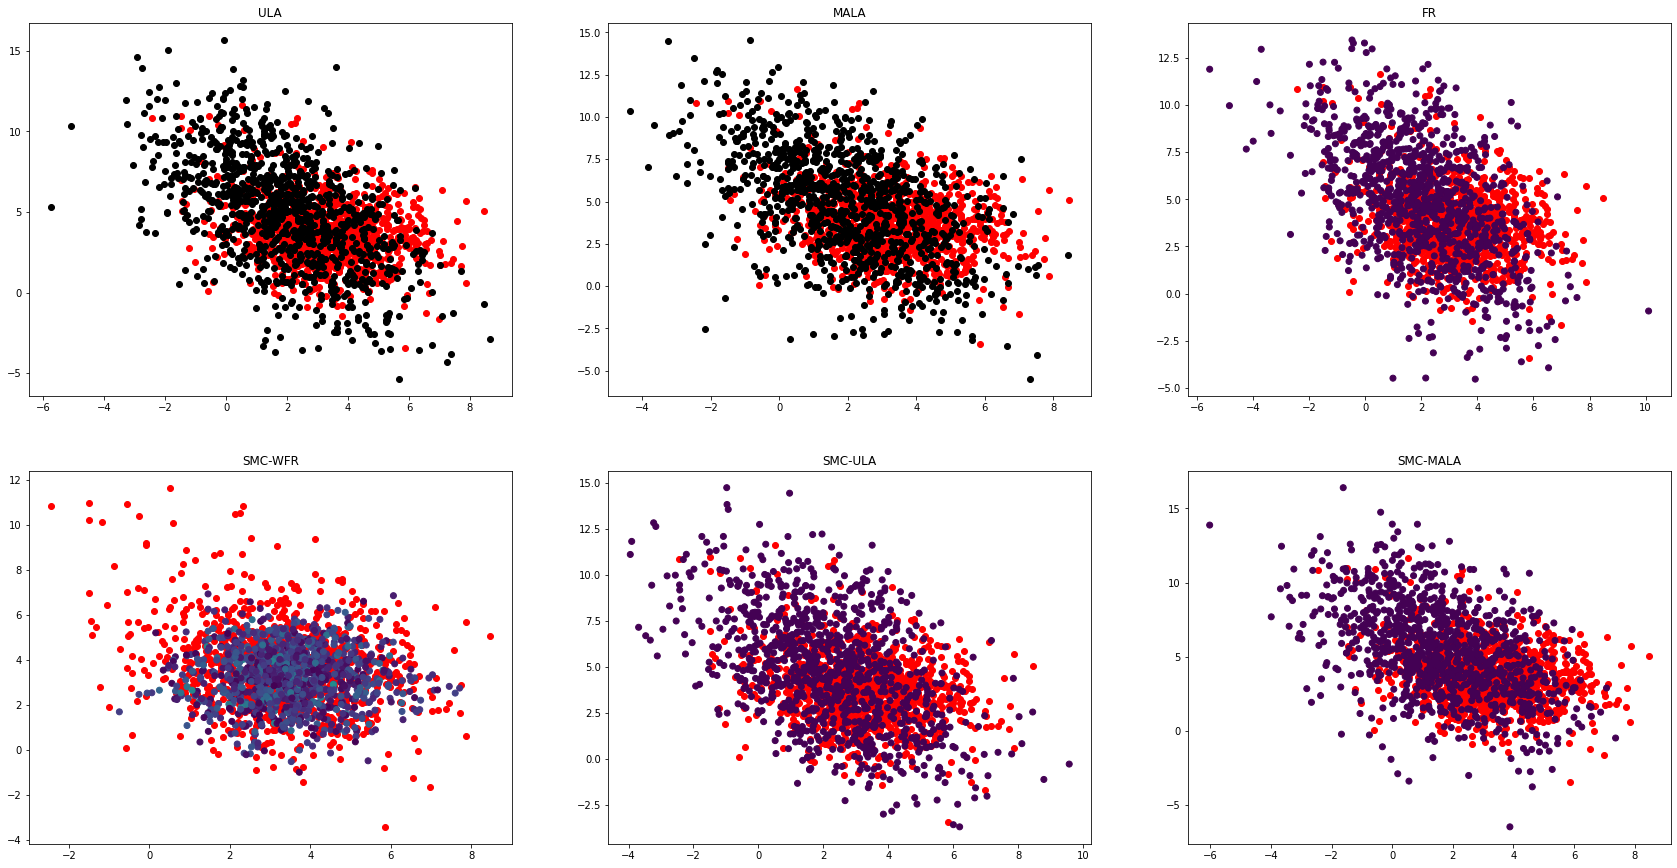

In [14]:
i = Nrep-1
plt.figure(figsize = (12,6))
plt.subplot(2, 3, 1)
plt.scatter(true_sample[:, 0], true_sample[:, 1], color = 'red');
plt.scatter(ula_chain[0, :], ula_chain[1, :], color = 'black');
plt.title('ULA')
plt.subplot(2, 3, 2)
plt.scatter(true_sample[:, 0], true_sample[:, 1], color = 'red');
plt.scatter(mala_chain[0, :], mala_chain[1, :], color = 'black');
plt.title('MALA')
plt.subplot(2, 3, 3)
plt.scatter(true_sample[:, 0], true_sample[:, 1], color = 'red');
plt.scatter(fr_x[0, :], fr_x[1, :], c = fr_w);
plt.title('FR')
plt.subplot(2, 3, 4)
plt.scatter(true_sample[:, 0], true_sample[:, 1], color = 'red');
plt.scatter(wfr_x[0, :], wfr_x[1, :], c = wfr_w);
plt.title('SMC-WFR')
plt.subplot(2, 3, 5)
plt.scatter(true_sample[:, 0], true_sample[:, 1], color = 'red');
plt.scatter(smcula_x[0, :], smcula_x[1, :], c = smcula_w);
plt.title('SMC-ULA')
plt.subplot(2, 3, 6)
plt.scatter(true_sample[:, 0], true_sample[:, 1], color = 'red');
plt.scatter(smcmala_x[0, :], smcmala_x[1, :], c = smcmala_w);
plt.title('SMC-MALA')
# plt.colorbar();
plt.subplots_adjust(left=-1,
                    bottom=-1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
plt.show()

In [15]:
np.mean(np.sum(accepted_mala, axis = 0)/Niter_mala)

0.5628909999999999

In [16]:
np.mean(np.sum(accepted_smcmala, axis = 0)/Niter_smcmala)

0.563612

In [17]:
avg_runtime = np.mean(runtime, axis = 0)
avg_runtime[3]/avg_runtime

array([0.92220256, 1.07283719, 0.93683925, 1.        , 1.22712519,
       0.96886281])

In [18]:
xx_ula = avg_runtime[0]/Niter_ula*np.arange(Niter_ula)
xx_mala = avg_runtime[1]/Niter_mala*np.arange(Niter_mala)
xx_fr = avg_runtime[2]/Niter_fr*np.arange(Niter_fr)
xx_wfr = avg_runtime[3]/Niter*np.arange(Niter)
xx_smcula = avg_runtime[4]/Niter_smcula*np.arange(Niter_smcula)
xx_smcmala = avg_runtime[5]/Niter_smcmala*np.arange(Niter_smcmala)

In [19]:
w1_ula_plot = np.mean(np.mean(w1_ula, axis = 0), axis = 1)
w1_mala_plot = np.mean(np.mean(w1_mala, axis = 0), axis = 1)
w1_fr_plot = np.mean(np.mean(w1_fr, axis = 0), axis = 1)
w1_wfr_plot = np.mean(np.mean(w1_wfr, axis = 0), axis = 1)
w1_smcula_plot = np.mean(np.mean(w1_smcula, axis = 0), axis = 1)
w1_smcmala_plot = np.mean(np.mean(w1_smcmala, axis = 0), axis = 1)

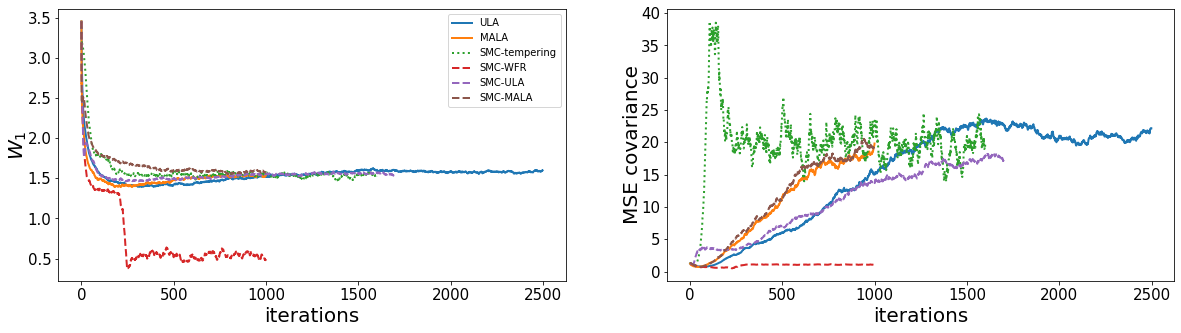

In [20]:
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.plot(w1_ula_plot, label = 'ULA', lw = 2)
plt.plot(w1_mala_plot, label = 'MALA', lw = 2)
plt.plot(w1_fr_plot, label = 'SMC-tempering', lw = 2, linestyle = 'dotted')
plt.plot(w1_wfr_plot, label = 'SMC-WFR', lw = 2, linestyle = 'dashed')
plt.plot(w1_smcula_plot, label = 'SMC-ULA', lw = 2, linestyle = 'dashed')
plt.plot(w1_smcmala_plot, label = 'SMC-MALA', lw = 2, linestyle = 'dashed')
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.legend();
plt.subplot(1, 2, 2)
plt.plot(np.mean(cov_ula, axis = 0), lw = 2)
plt.plot(np.mean(cov_mala, axis = 0), lw = 2)
plt.plot(np.mean(cov_fr, axis = 0), lw = 2, linestyle = 'dotted')
plt.plot(np.mean(cov_wfr, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(np.mean(cov_smcula, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(np.mean(cov_smcmala, axis = 0), lw = 2, linestyle = 'dashed')
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('MSE covariance', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig('setup2.pdf', bbox_inches="tight")

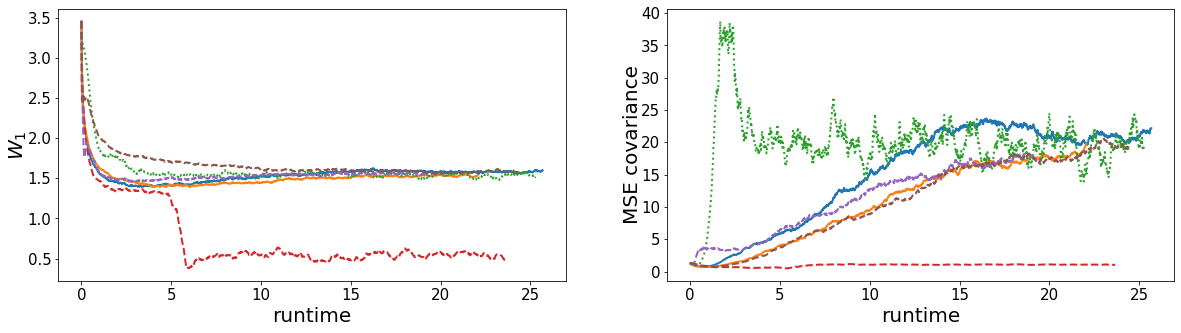

In [21]:
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.plot(xx_ula, w1_ula_plot, label = 'ULA', lw = 2)
plt.plot(xx_mala, w1_mala_plot, label = 'MALA', lw = 2)
plt.plot(xx_fr, w1_fr_plot, label = 'SMC-tempering', lw = 2, linestyle = 'dotted')
plt.plot(xx_wfr, w1_wfr_plot, label = 'SMC-WFR', lw = 2, linestyle = 'dashed')
plt.plot(xx_smcula, w1_smcula_plot, label = 'SMC-ULA', lw = 2, linestyle = 'dashed')
plt.plot(xx_smcmala, w1_smcmala_plot, label = 'SMC-MALA', lw = 2, linestyle = 'dashed')
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.subplot(1, 2, 2)
plt.plot(xx_ula, np.mean(cov_ula, axis = 0), lw = 2)
plt.plot(xx_mala, np.mean(cov_mala, axis = 0), lw = 2)
plt.plot(xx_fr, np.mean(cov_fr, axis = 0), lw = 2, linestyle = 'dotted')
plt.plot(xx_wfr, np.mean(cov_wfr, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(xx_smcula, np.mean(cov_smcula, axis = 0), lw = 2, linestyle = 'dashed')
plt.plot(xx_smcmala, np.mean(cov_smcmala, axis = 0), lw = 2, linestyle = 'dashed')
plt.xlabel('runtime', fontsize = 20)
plt.ylabel('MSE covariance', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# plt.savefig('gm2d_runtime.pdf', bbox_inches="tight")

## Zoom into SMC tempering & SMC-WFR

In [22]:
w1_fr_se = 2*np.std(np.mean(w1_fr, axis = 0), axis = 1)
w1_wfr_se = 2*np.std(np.mean(w1_wfr, axis = 0), axis = 1)

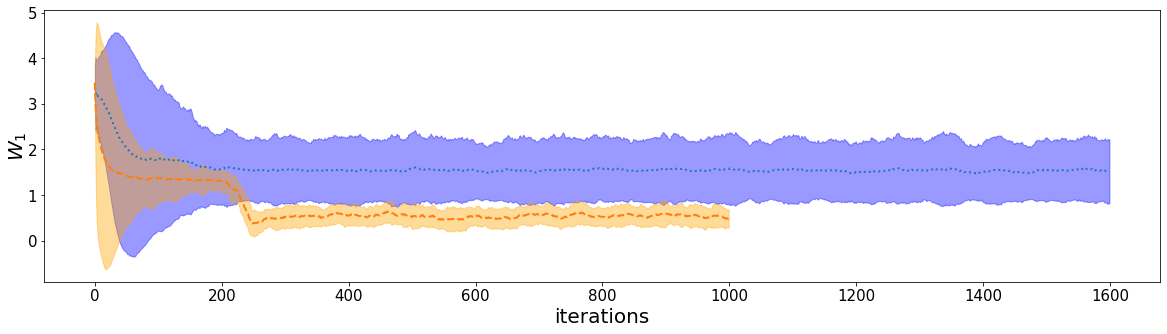

In [23]:
plt.figure(figsize = (20,5))
plt.plot(w1_fr_plot, label = 'SMC-tempering', lw = 2, linestyle = 'dotted')
plt.fill_between(np.arange(Niter_fr), (w1_fr_plot-w1_fr_se), (w1_fr_plot+w1_fr_se), color='b', alpha=.4)
plt.plot(w1_wfr_plot, label = 'SMC-WFR', lw = 2, linestyle = 'dashed')
plt.fill_between(np.arange(Niter), (w1_wfr_plot-w1_wfr_se), (w1_wfr_plot+w1_wfr_se), color='orange', alpha=.4)
plt.xlabel('iterations', fontsize = 20)
plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
# legend = plt.legend(loc = 'lower center', bbox_to_anchor=(1, -0.5), ncol = 6, fontsize = 20)